# Graph Isomorphism and Jumping Knowledge

Xu et al. (2018) posit that a GNN with maximal discriminative power could distinguish between distinct graph structures by mapping them onto unique representations in the embedding space. To achieve this, they proposed the Graph Isomorphism Network (GIN), a neural network architecture that extends the Weisfeiler-Lehman test. By doing so, they could ensure that isomorphic graphs were mapped onto identical representations while non-isomorphic graphs were mapped onto distinct ones. Furthermore, they have demonstrated that the GIN achieves the greatest discriminative power among all GNNs. Subsequently, Hu et al. (2019) augmented the GIN model with a pre-training strategy to mitigate negative transfer effects in downstream tasks, leading to promising results on benchmark datasets.

Given a pair of graphs $\mathcal{G}_1$ and $\mathcal{G}_2$, Hamilton (2023) summerized the goal of graph isomorphism testing is to declare whether or not these two graphs are isomorphic, formally, if or not the following conditions hold

$$
\textbf{P}\textbf{A}_1\textbf{P}^{\top} = \textbf{A}_2 \text{ and } \textbf{P}\textbf{X}_1 = \textbf{X}_2
$$

where $\textbf{P}$ is a permutation matrix, $\textbf{A}_1$ and $\textbf{A}_2$ are adjacency matrices of $\mathcal{G}_1$ and $\mathcal{G}_2$, as well as node features $\textbf{X}_1$ and $\textbf{X}_2$.

Jumping Knowledge (JK) (Xu et al., 2018) is a network architecture that can be combined with GIN, providing an adaptive means to adjust the influence radii of each node and task through the selective combination of various aggregations at the final layer. In other words, it breaks the assumption of utilizing the output of the final layer of the GNN. Thus, it could facilitate improved structure-aware representations. In this approch, Hamilton (2023) defined the final node representations $\textbf{z}_u$ as

$$
\textbf{z}_u = f_{\text{JK}} \left( \textbf{h}_u^{(0)} \oplus \textbf{h}_u^{(1)} \oplus \cdots \oplus \textbf{h}_u^{(K)} \right)
$$

where $f_{\text{JK}}$ is an arbitrary differentiable function.

In our study, we employed DGL-LifeSci and RdKit to integrate the pre-training strategies of GIN and JK. To perform featurization of chemical compounds, we one-hot encoded atoms and their corresponding chiralities into graphs, which also accounted for four types of chemical bonds (single, double, triple, and aromatic) and three directions of bonds (end upright, end downright, and none).

In [2]:
import sys

sys.path.insert(0, '..')

In [3]:
from data.dataset import Dataset
import torch
from sklearn.metrics import mean_squared_error, r2_score
from data.featurization.dgl_Graph import DGL_Graph
from model.abstractmodel import AbstractModel
import pandas as pd

In [4]:
TRN = Dataset.load_csv("ds/TRN_DC")
TST = Dataset.load_csv("ds/TST")

In [5]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Pretrain",
    self_loop=True
)
TRN.X = TRN.featurize(featurizer)
TST.X = TST.featurize(featurizer)

In [6]:
trn_sets, val_sets = TRN.k_fold_split(5)

In [12]:
from model.dgl.GIN import GIN

num_heads = 5
AbstractModel.set_seed(2387)

k_pred_tst1 = []
k_pred_tst2 = []

for trn, val in zip(trn_sets, val_sets):
    model = GIN(
        task_type="regression",
        # GIN Configuration
        pretrained='gin_supervised_contextpred',
        n_tasks=1,
        num_node_emb_list=[
            len(featurizer.node_featurizer._atomic_number_types) + 1,
            len(featurizer.node_featurizer._chiral_types) + 1
        ],
        num_edge_emb_list=[
            len(featurizer.edge_featurizer._bond_types) + 1,
            len(featurizer.edge_featurizer._bond_direction_types) + 1
        ],
        num_layers=5,
        emb_dim=208,
        JK="last",
        dropout=0.5471241966662174,
        readout="mean",
        # Abstract DGL Configuration
        lr=0.001,
        y_name="LogS exp (mol/L)",
        weight_decay=0,
        batch_size=1024
    )
    model.fit(trn, val=val, epochs=400, min_epoch=0, early_stop=20)
    k_pred_tst1.append(model.predict(TST).cpu())

[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 10%|█         | 40/400 [00:02<00:26, 13.72it/s, loss: 1.753 rmse: 1.685]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 19%|█▉        | 76/400 [00:05<00:23, 14.00it/s, loss: 0.941 rmse: 1.932]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 17%|█▋        | 67/400 [00:04<00:24, 13.86it/s, loss: 1.118 rmse: 1.471]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 12%|█▎        | 50/400 [00:03<00:24, 14.00it/s, loss: 1.355 rmse: 1.693]


[INFO] Expect to use 'DGL_Graph_Pretrain' to featurize SMILES
[INFO] Device cuda


 22%|██▏       | 87/400 [00:06<00:22, 13.84it/s, loss: 0.803 rmse: 1.410]


In [13]:
pred_tst1 = [torch.mean(pred_i).item() for pred_i in torch.cat(k_pred_tst1, 1)]

In [14]:
print(f"TST : RMSE {mean_squared_error(TST.y, pred_tst1, squared=False)}")
print(f"TST : R^2 {r2_score(TST.y, pred_tst1)}")

TST : RMSE 1.2065800267216644
TST : R^2 0.20971228925582297


Text(0.5, 1.0, '2008 Solubility Challenge Test Set (GIN)\nRMSE: 1.207, $R^2$: 0.210')

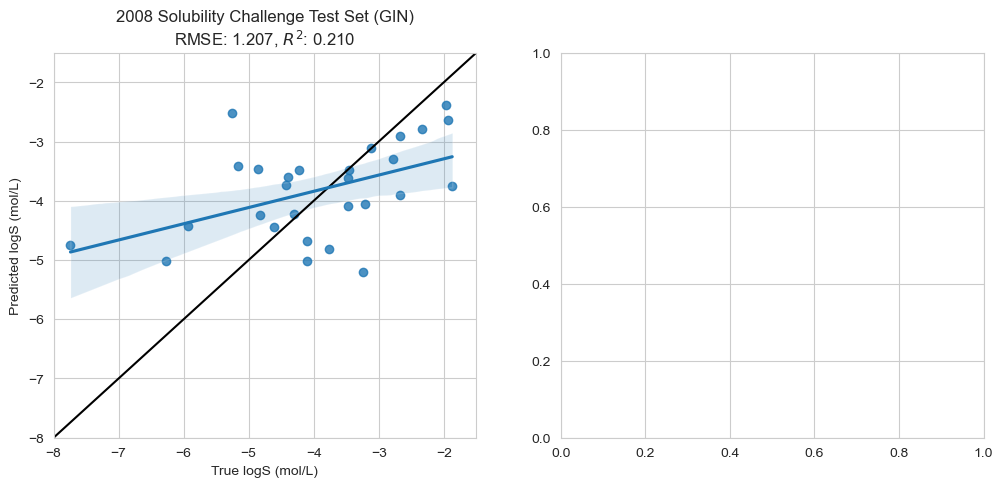

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GIN"
min_ax1, max_ax1 = -8, -1.5

fig, (ax1, _) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True logS (mol/L)": TST.y.values[:, 0],
        "Predicted logS (mol/L)": pred_tst1
    }),
    x="True logS (mol/L)",
    y="Predicted logS (mol/L)",
    ax=ax1
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)

ax1.set_title(f"2008 Solubility Challenge Test Set ({model_name})\n"
              f"RMSE: {mean_squared_error(TST.y, pred_tst1, squared=False):.3f}, $R^2$: {r2_score(TST.y, pred_tst1):.3f}")